In [1]:
!pip install -r requirements.txt

In [2]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid")

In [3]:
# inspired by https://stackoverflow.com/questions/18603270/progress-indicator-during-pandas-operations
# nicely prints progress of lengthy pandas calculation in jupyter notebook
from tqdm.auto import tqdm 
tqdm.pandas()

In [4]:
from settings import SimulationSetup
from helper import rdd_dose_Gy, rdd_dose_Gy_basic
from printing import pretty_print

In [5]:
# create an array of values to be used for horizontal axis of RDD vs radius plot
# this is distance from ion track in meters

points_per_decade = 10
start_at_exponent = -11
stop_at_exponent = -7

no_of_decades = stop_at_exponent-start_at_exponent
no_of_samples = no_of_decades * points_per_decade + 1

r_m = np.logspace(start=start_at_exponent, stop=stop_at_exponent, num=no_of_samples)

In [6]:
simulation_setup = SimulationSetup()

# all necessary parameters
a0_nm = 5
E_MeV_u = 150.
simulation_setup.beam.particle_name = "1H"
simulation_setup.material.material_name = "Water, Liquid"
simulation_setup.tst_model.rdd_model_name = "RDD_Geiss"

# we will calculate RDD just for a single energy value
simulation_setup.beam.start_E_MeV_u = E_MeV_u
simulation_setup.beam.stop_E_MeV_u = simulation_setup.beam.start_E_MeV_u
simulation_setup.beam.num_E_MeV_u = 1

# some of the options in simulation setup are not needed for RDD calculation,
# instead of leaving default values, we set those items to `nan` (not-a-number) or to `None`

# just a single value of a0 parameter, note that final `,` is needed in python to define a single-element tuple
simulation_setup.tst_model.a0_nm = (a0_nm,)

# model of response to reference radiation (gamma) is not needed for RDD calculations
simulation_setup.gamma_response_model = None  

# there is no need to specify slab thickness for RDD calculation
simulation_setup.beam.dose_gy = float('nan')

# there is no need to specify slab thickness and saturation cross-section for RDD calculation
simulation_setup.material.slab_thickness_um = float('nan')
simulation_setup.saturation_cross_section_factor = float('nan')

simulation_setup

SimulationSetup(beam=BeamSetup(particle_name='1H', start_E_MeV_u=150.0, stop_E_MeV_u=150.0, num_E_MeV_u=1, dose_gy=nan), material=DetectorPropertySetup(material_name='Water, Liquid', slab_thickness_um=nan), gamma_response_model=None, tst_model=TrackStructureModel(er_model_name='ER_Edmund', rdd_model_name='RDD_Geiss', a0_nm=(5,)), stopping_power_source_name='PSTAR', saturation_cross_section_factor=nan)

In [7]:
pretty_print(simulation_setup)

SimulationSetup(
    beam=BeamSetup(
        particle_name='1H',
        start_E_MeV_u=150.0,
        stop_E_MeV_u=150.0,
        num_E_MeV_u=1,
        dose_gy=nan,
    ),
    material=DetectorPropertySetup(
        material_name='Water, Liquid',
        slab_thickness_um=nan,
    ),
    gamma_response_model=None,
    tst_model=TrackStructureModel(
        er_model_name='ER_Edmund',
        rdd_model_name='RDD_Geiss',
        a0_nm=(
            5,
        ),
    ),
    stopping_power_source_name='PSTAR',
    saturation_cross_section_factor=nan,
)


In [8]:
d_Gy = rdd_dose_Gy(r_m=r_m, sim_setup=simulation_setup)

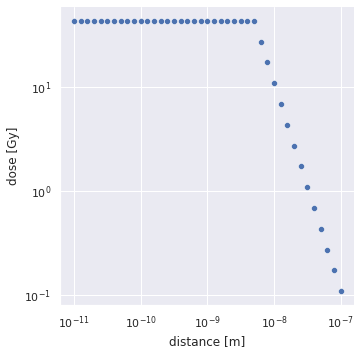

In [9]:
g = sns.relplot(x=r_m, y=d_Gy)
g.set(xscale='log');
g.set(yscale='log');
g.set(xlabel='distance [m]');
g.set(ylabel='dose [Gy]');

In [10]:
# iterating through dictionary is equivalent to R expand.grid
data_dict = {
    'r_m': r_m,
    'd_Gy': (0.,),
    'rdd_model_name': ('RDD_Geiss', 'RDD_KatzPoint', 'RDD_KatzSite', 'RDD_CucinottaPoint', 'RDD_KatzExtTarget')
}
df = pd.DataFrame.from_records(data=itertools.product(*data_dict.values()), columns=data_dict.keys())
df.head()

,r_m,d_Gy,rdd_model_name
0,1.000000e-11,0.0,RDD_Geiss
1,1.000000e-11,0.0,RDD_KatzPoint
2,1.000000e-11,0.0,RDD_KatzSite
3,1.000000e-11,0.0,RDD_CucinottaPoint
4,1.000000e-11,0.0,RDD_KatzExtTarget


In [11]:
for rdd_model_name, df_single_pass in df.groupby('rdd_model_name'):
    df.loc[df.rdd_model_name == rdd_model_name, 'd_Gy'] = rdd_dose_Gy_basic(r_m=df_single_pass.r_m, rdd_model_name=rdd_model_name)

In [12]:
df.head()

,r_m,d_Gy,rdd_model_name
0,1.000000e-11,0.0,RDD_Geiss
1,1.000000e-11,0.0,RDD_KatzPoint
2,1.000000e-11,0.0,RDD_KatzSite
3,1.000000e-11,0.0,RDD_CucinottaPoint
4,1.000000e-11,0.0,RDD_KatzExtTarget


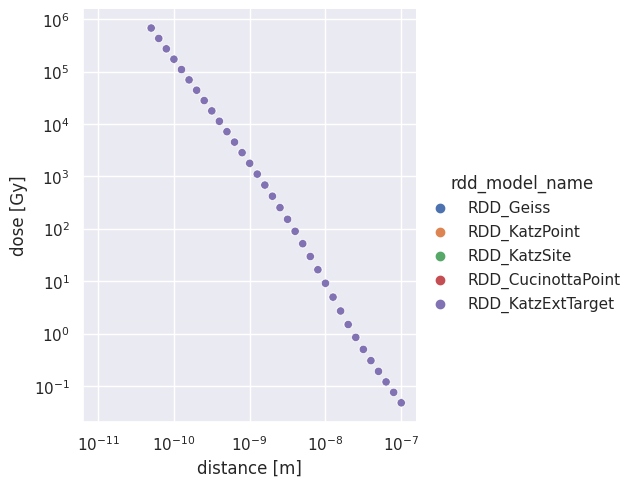

In [13]:
g = sns.relplot(x='r_m', y='d_Gy', hue='rdd_model_name', data = df)
g.set(xscale='log');
g.set(yscale='log');
g.set(xlabel='distance [m]');
g.set(ylabel='dose [Gy]');